<a href="https://colab.research.google.com/github/JoseJD7/proyecto_neuralclusters/blob/master/Copia_de_Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [0]:
!pip install --pre --quiet astroquery

     |████████████████████████████████| 4.3MB 3.4MB/s 
     |████████████████████████████████| 61kB 19.8MB/s 
     |████████████████████████████████| 2.3MB 14.3MB/s 
     |████████████████████████████████| 102kB 27.9MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0


## Datos del SDSS

Disponible en enlace



###Consulta con Astroquery###

In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 100000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z, s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'STAR'
                      
                      """)

In [0]:
datapd=data.to_pandas()
datapd = datapd[(datapd != -9999).dropna()]
datapd = datapd.dropna()
print(datapd)

       fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0        23.96692    23.71592    22.07448    20.88824    20.17535        6537
1        22.45498    21.39898    21.14221    21.13898    21.19300        4949
2        23.04208    22.43817    22.21309    22.59951    21.13734        3900
3        23.23459    22.13259    21.89314    21.59264    20.95732        7652
4        23.84488    22.24959    21.81773    21.63126    21.57564        5807
5        19.88988    18.97729    18.61057    18.45963    18.40128        9899
6        22.88934    21.56195    21.29082    21.07423    21.40925        4949
7        22.09479    21.05033    20.85268    20.66345    20.33288        4949
8        21.94799    20.72320    20.20987    20.35761    20.02630        9899
9        22.00782    20.80491    20.49119    20.43349    20.84085        4662
10       20.98806    20.01780    19.80793    19.71838    19.42414        3900
11       23.06621    21.78392    21.78530    22.13173    21.4238

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)

### Chequeo a los datos

Estadísticas:

In [0]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,79988.0,20.973024,2.113711,14.01740,19.413077,20.775560,22.606797,26.94147
fiberMag_g,79988.0,19.577631,1.991266,13.51540,18.106253,19.426890,21.239757,28.84941
fiberMag_r,79988.0,18.970401,1.881092,12.84478,17.515595,18.928100,20.578902,25.23663
fiberMag_i,79988.0,18.637717,1.810723,12.73436,17.223698,18.640360,20.095367,26.08713
fiberMag_z,79988.0,18.444477,1.797687,12.13546,17.056623,18.400075,19.842400,23.82155


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [0]:
norm_train_labels = norm(train_labels)
norm_train_feat = norm(train_feat)

norm_test_feat = norm(test_feat)

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

###Estructura de la red neuronal

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    layers.Dense(0, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

W0709 04:30:06.170280 139875002005376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


###Desnormalización

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo

### Inspección del modelo

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 0)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [0]:
# Imprime un punto por cada epoch completado
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

El progreso de entrenamiento del sistema está en el objeto `history`.

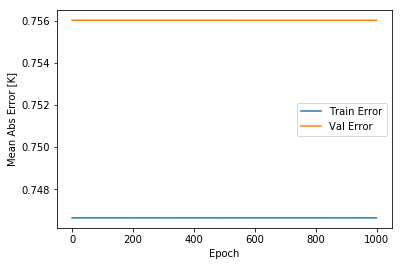

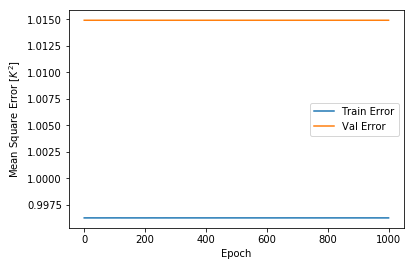

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

###Tiempo de Ejecución

In [0]:
t_fin = time()
t_ejecucion = t_fin - t_ini

### Predicción con los datos de prueba

(-59187.766251756846, 17047.23471576391, -59187.77365081527, 17047.22731670549)

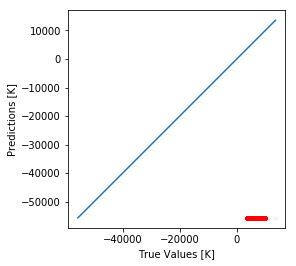

In [0]:
test_predictions = model.predict(norm_test_feat).flatten()

test_predictions = desnorm(test_predictions, train_labels.mean(), train_labels.std())
m1 = min(test_labels)
M1 = max(test_labels)

m2 = min(test_predictions)
M2 = max(test_predictions)

m = min([m1, m2])
M = max([M1, M2])

plt.scatter(test_labels, test_predictions,s=10, alpha = 0.01,color='red')
plt.plot([m , M], [m, M])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

Notemos que nuestro modelo se debe acercar a la función de  identidad. Ahora veamos la distribución del error absoluto:



### Errores

Tiempo de Ejecución: 2393.264443874359
Error Absoluto Medio: 61283.7265625
Error Cuadrático Medio: 3758053120.0


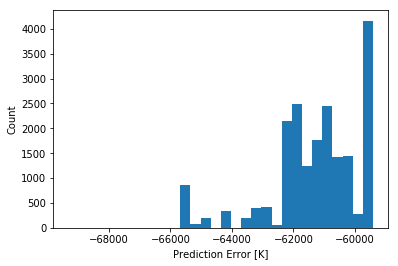

In [0]:
import numpy as np
error = test_predictions - test_labels
error2 = error**2

plt.hist(error, bins = 30)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

MeanAbsError = np.abs(error).mean()
MeanSQError = error2.mean()

print('Tiempo de Ejecución:', t_ejecucion)
print('Error Absoluto Medio:', MeanAbsError)
print('Error Cuadrático Medio:', MeanSQError)